# Districts (Local Files)

District should be derived using a car-based street network and for an area that is larger than the case study area (see below, e.g. for the city centre of London one should use Greater London)

In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None

import cityImage as ci

## Acquiring the Street Network

In [2]:
city_name = 'Tripoli'
epsg = 22780
crs = 'EPSG:'+str(epsg)

### Loading the **drive** network from Local files

In [6]:
input_path = '../data/'+city_name

nodes_graph = gpd.read_file(input_path+'_nodes.gpkg', driver="GPKG")
edges_graph = gpd.read_file(input_path+'_edges.gpkg', driver="GPKG")

nodes_graph, edges_graph = nodes_graph.to_crs(crs), edges_graph.to_crs(crs)
    
nodes_graph.index, edges_graph.index, = nodes_graph.nodeID, edges_graph.edgeID
nodes_graph.index.name, edges_graph.index.name, = None, None

### Cleaning and simplyfing the Street Network

At the end of the previous section two files are obtained: nodes and edges (vertexes and links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle (through boolean parameters):
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* `remove_islands`: Disconnected islands.
* `dead_ends` Dead-end street segments.
* `self_loops` Self-Loops.
* `same_vertexes_edges` Edges with same from-to nodes, but different geometries.
* `fix_topology` This creates nodes and breaks street segments at intersections. It is primarily useful for poorly formed datasets (usually OSM deerived networks are topologically correct). It accounts for segments classified as bridges or tunnels in OSM.

`same_vertexes_edges` handles edges with same pair of u-v nodes but different geometries. When `True`, it derives a center line between the two segments, unless one of the two segments is longer than the other (>10%). In this case, the shorter segment is deleted.

In [7]:
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = True,
                            same_vertexes_edges = True, self_loops = True, fix_topology = False)

**Visualisation**

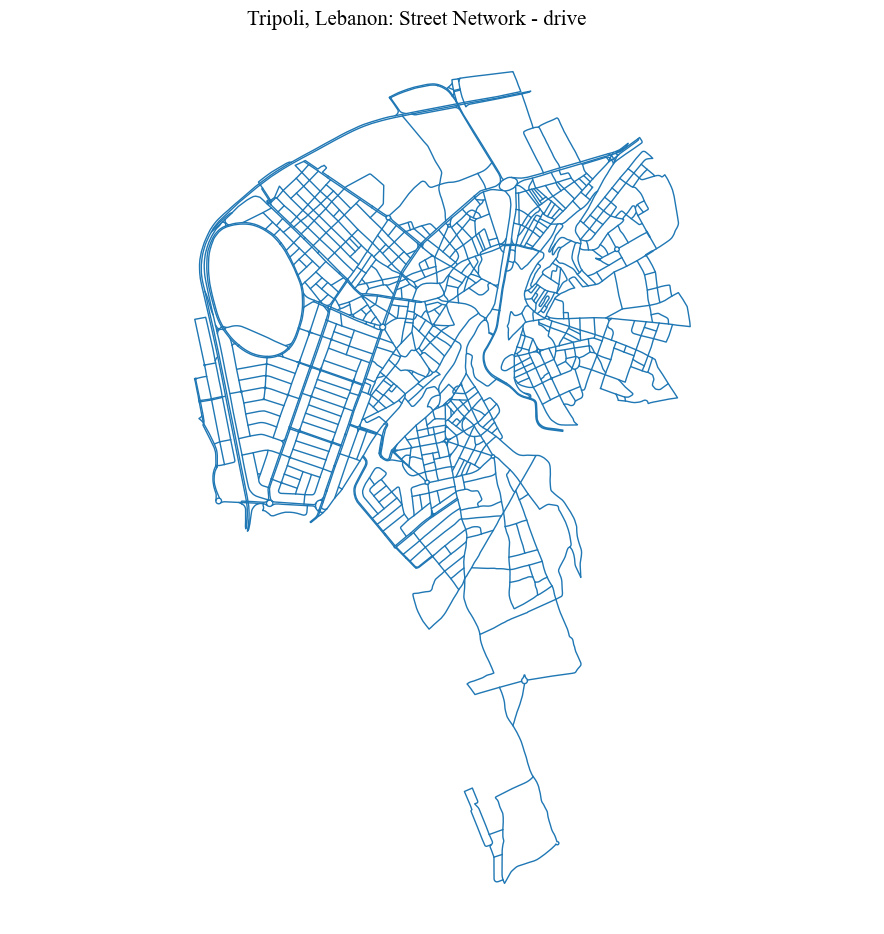

In [8]:
fig = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), title = city_name+': Street Network - drive')

## District identification

In [10]:
# creating the dual_graph
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

Different weights can be used to extract the partitions. `None` indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as `p_name_weight` (e.g. `p_length`).

In [11]:
weights = ['length', 'rad', None]
districts = edges_graph.copy()
for weight in weights:
    districts = ci.identify_regions(dual_graph, districts, weight = weight)

**Visualisation**

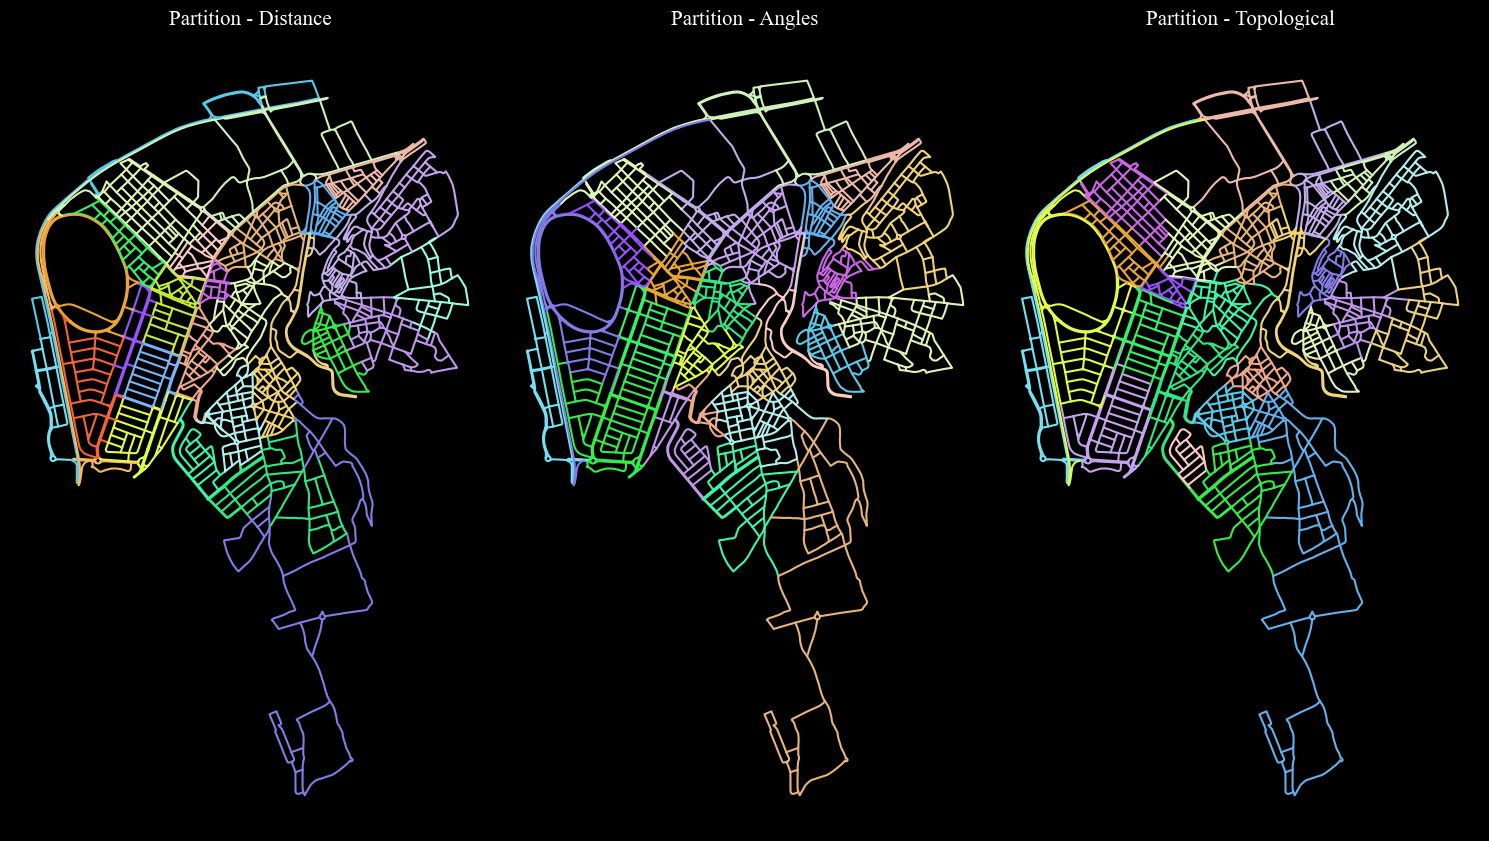

In [12]:
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(districts, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10), ncols = 3, nrows = 1)

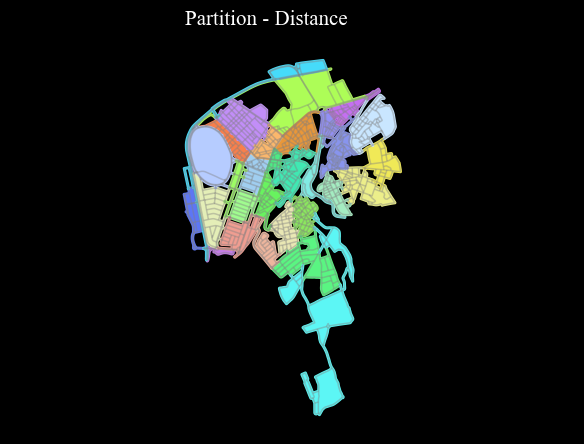

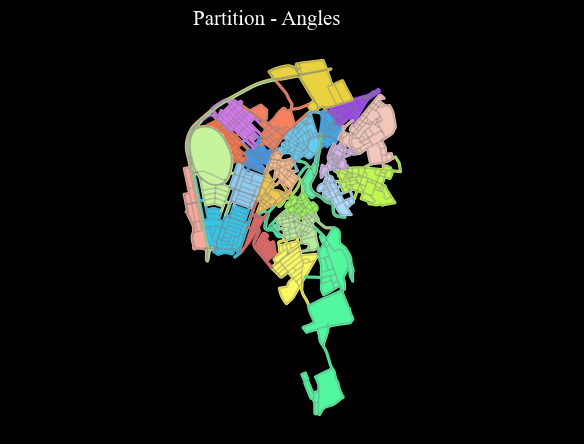

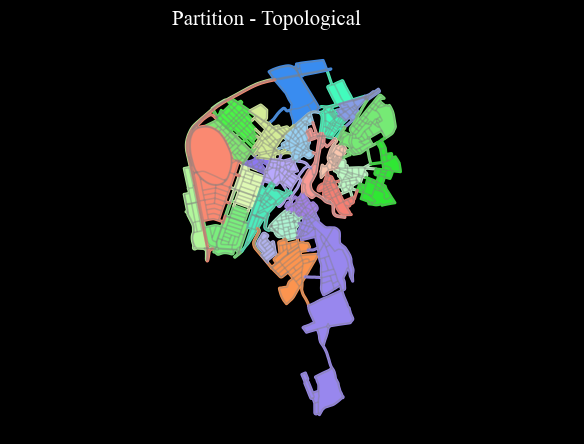

In [13]:
for n, column in enumerate(columns):
    cmap = ci.rand_cmap(nlabels = len(districts[column].unique()), type_color='bright')
    partitions = ci.polygonise_partitions(districts, column, convex_hull = False)
    ci.plot_gdf(partitions, column = column, cmap = cmap, title =  titles[n], black_background = True,  figsize = (7, 5), 
               base_map_gdf = districts, base_map_color = 'grey', base_map_zorder = 1)

**Exporting**

In [14]:
# provide path
output_path = '../output/'+city_name
ci.remove_lists_columns(districts).to_file(output_path+"_edges_districts.gpkg",  driver="GPKG")

## Optional: Assigning regions to a sub-case study area'snetwork (From OSM relation or polygon)

In [35]:
# study_area_polygon = ox.geocode_to_gdf("Tripoli, Lebanon").to_crs(crs).iloc[0].geometry
study_area_polygon = gpd.read_file("../data/Tripoli_boundary.gpkg",  driver="GPKG").iloc[0].geometry.buffer(50)
el_mina_tripoli_districts = districts[districts.geometry.within(study_area_polygon)]

**Visualisation**

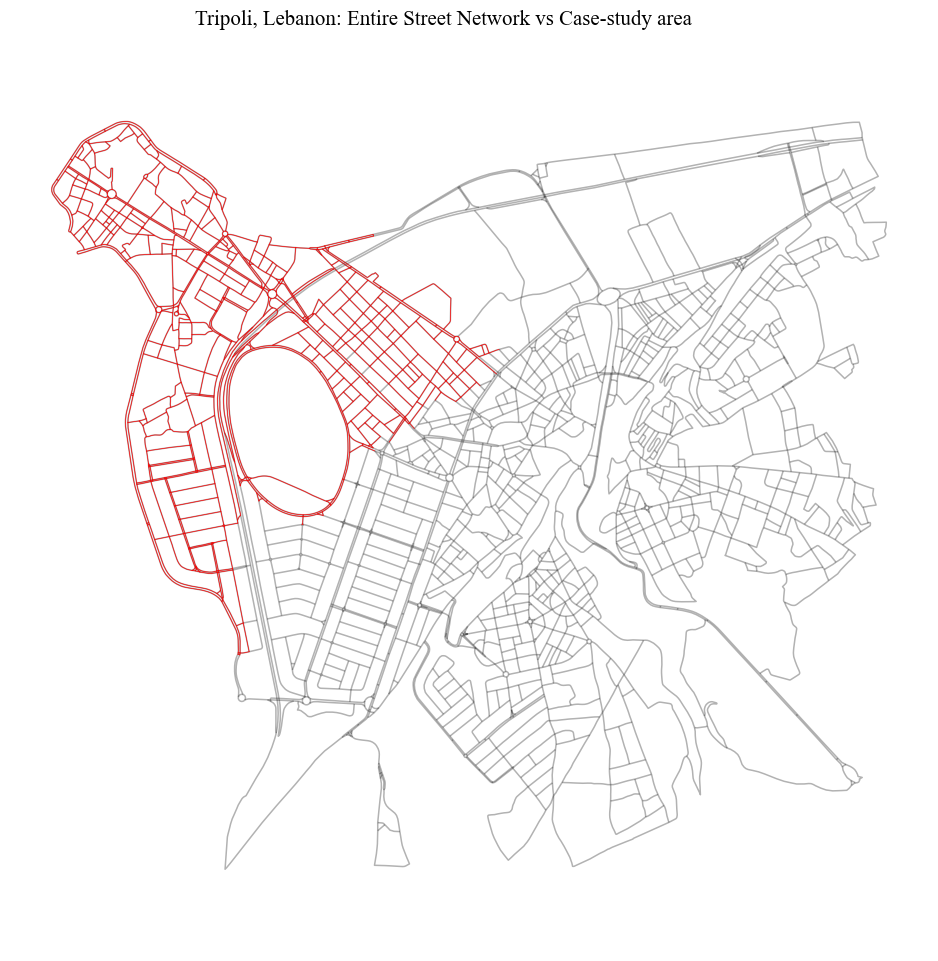

In [36]:
fig = ci.plot_gdf(el_mina_tripoli_districts, scheme = None,  black_background = False, figsize = (10,10), title = 
              city_name+': Entire Street Network vs Case-study area', color = 'red', geometry_size = 0.5,
             base_map_gdf = districts, base_map_color = 'black', base_map_alpha = 0.3)

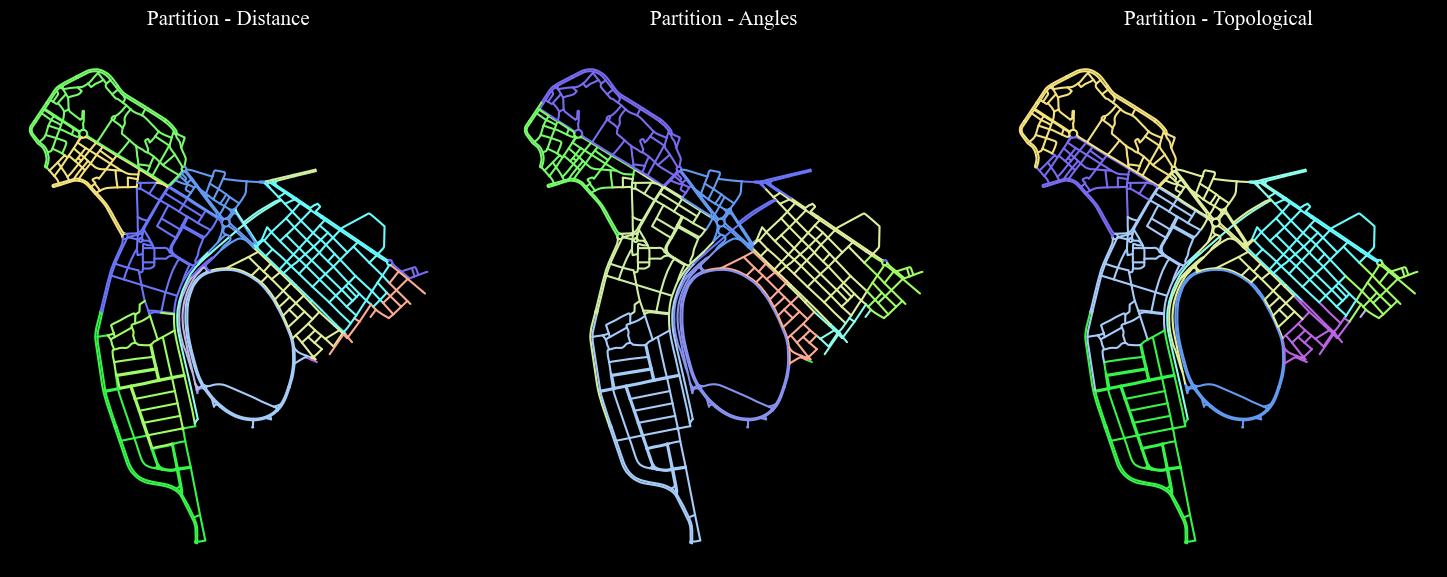

In [38]:
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(el_mina_tripoli_districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(el_mina_tripoli_districts, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10), ncols = 3, nrows = 1)

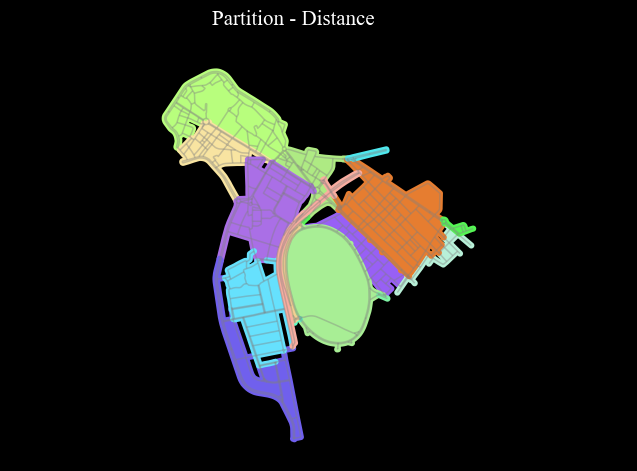

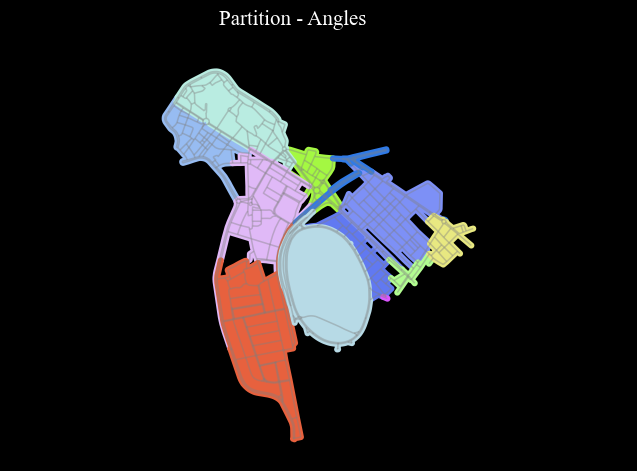

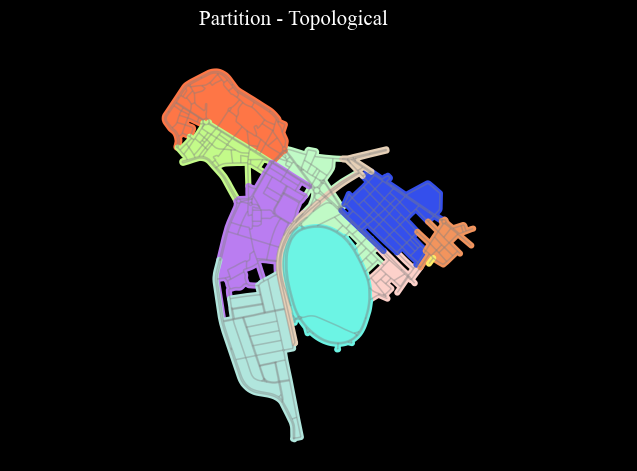

In [39]:
for n, column in enumerate(columns):
    cmap = ci.rand_cmap(nlabels = len(el_mina_tripoli_districts[column].unique()), type_color='bright')
    partitions = ci.polygonise_partitions(el_mina_tripoli_districts, column, convex_hull = False)
    ci.plot_gdf(partitions, column = column, cmap = cmap, title =  titles[n], black_background = True,  figsize = (7, 5), 
               base_map_gdf = el_mina_tripoli_districts, base_map_color = 'grey', base_map_zorder = 1)

**Exporting**

In [40]:
el_mina_tripoli_districts.to_file("../output/el_mina_tripoli_districts.gpkg", driver="GPKG")